### Analysis of Source Data

Import bibliotek wykorzystywanych do projektu oraz pliku z danymi 'bitcoin.csv'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from scipy.stats import randint, uniform
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
%matplotlib inline 

In [3]:
df= pd.read_csv('bitcoin.csv')

In [4]:
df

,date,price,total_volume,market_cap,coin_name
0,2015-01-01 00:00:00.000,313.992000,4.699936e+07,4.293958e+09,bitcoin
1,2015-01-02 00:00:00.000,314.446000,3.885591e+07,4.301448e+09,bitcoin
2,2015-01-03 00:00:00.000,286.572000,1.187789e+08,3.921358e+09,bitcoin
3,2015-01-04 00:00:00.000,260.936000,2.055001e+08,3.571640e+09,bitcoin
4,2015-01-05 00:00:00.000,273.220000,1.550381e+08,3.740880e+09,bitcoin
...,...,...,...,...,...
3295,2024-01-10 00:00:00.000,46105.946078,3.988792e+10,9.021669e+11,bitcoin
3296,2024-01-11 00:00:00.000,46632.313148,5.203006e+10,9.152593e+11,bitcoin
3297,2024-01-12 00:00:00.000,46314.355542,4.919813e+10,9.098464e+11,bitcoin
3298,2024-01-13 00:00:00.000,42893.929606,4.591330e+10,8.383835e+11,bitcoin


The next step will be data cleaning.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          3300 non-null   object 
 1   price         3300 non-null   float64
 2   total_volume  3300 non-null   float64
 3   market_cap    3299 non-null   float64
 4   coin_name     3300 non-null   object 
dtypes: float64(3), object(2)
memory usage: 129.0+ KB


In [6]:
unique_values = df['coin_name'].unique()
print(unique_values)

['bitcoin']


The "coin_name" column contains the name of a single cryptocurrency 'bitcoin', therefore it can be removed. Since the data represents a time series, it is advisable to set the 'date' column as the index.

In [7]:
df.drop(['coin_name'],axis=1,inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3300 non-null   datetime64[ns]
 1   price         3300 non-null   float64       
 2   total_volume  3300 non-null   float64       
 3   market_cap    3299 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 103.2 KB


The "market_cap" column contains a missing value. It is necessary to analyze the row with incomplete data and fill it in appropriately.

In [9]:
rows_with_null = df[df['market_cap'].isnull()]
print(rows_with_null)

          date     price  total_volume  market_cap
821 2017-04-02  1098.068  8.023151e+07         NaN


In [10]:
filtered_df = df[(df['date'] >= '2017-03-28') & (df['date'] <= '2017-04-10')]
print(filtered_df)

          date        price  total_volume    market_cap
816 2017-03-28  1044.722000  1.276436e+08  1.696879e+10
817 2017-03-29  1038.617198  1.211691e+08  1.687138e+10
818 2017-03-30  1031.492906  1.024388e+08  1.675784e+10
819 2017-03-31  1078.274711  1.332871e+08  1.751958e+10
820 2017-04-01  1085.253000  8.775043e+07  1.763483e+10
821 2017-04-02  1098.068000  8.023151e+07           NaN
822 2017-04-03  1139.308275  1.317652e+08  1.851790e+10
823 2017-04-04  1140.497590  1.082230e+08  1.853906e+10
824 2017-04-05  1132.339905  8.743962e+07  1.840873e+10
825 2017-04-06  1194.211000  1.283093e+08  1.941680e+10
826 2017-04-07  1189.775124  9.084018e+07  1.934705e+10
827 2017-04-08  1182.271000  4.389967e+07  1.922711e+10
828 2017-04-09  1187.699000  4.115143e+07  1.931619e+10
829 2017-04-10  1210.515000  7.605022e+07  1.969102e+10


In [11]:
df['market_cap'] = df['market_cap'].interpolate(method='linear')

In [12]:
filtered_df = df[(df['date'] >= '2017-03-28') & (df['date'] <= '2017-04-10')]
print(filtered_df)

          date        price  total_volume    market_cap
816 2017-03-28  1044.722000  1.276436e+08  1.696879e+10
817 2017-03-29  1038.617198  1.211691e+08  1.687138e+10
818 2017-03-30  1031.492906  1.024388e+08  1.675784e+10
819 2017-03-31  1078.274711  1.332871e+08  1.751958e+10
820 2017-04-01  1085.253000  8.775043e+07  1.763483e+10
821 2017-04-02  1098.068000  8.023151e+07  1.807637e+10
822 2017-04-03  1139.308275  1.317652e+08  1.851790e+10
823 2017-04-04  1140.497590  1.082230e+08  1.853906e+10
824 2017-04-05  1132.339905  8.743962e+07  1.840873e+10
825 2017-04-06  1194.211000  1.283093e+08  1.941680e+10
826 2017-04-07  1189.775124  9.084018e+07  1.934705e+10
827 2017-04-08  1182.271000  4.389967e+07  1.922711e+10
828 2017-04-09  1187.699000  4.115143e+07  1.931619e+10
829 2017-04-10  1210.515000  7.605022e+07  1.969102e+10


In [13]:
df.set_index('date', inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3300 entries, 2015-01-01 00:00:00 to 2024-01-14 00:00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         3300 non-null   float64
 1   total_volume  3300 non-null   float64
 2   market_cap    3300 non-null   float64
dtypes: float64(3)
memory usage: 103.1 KB


Linear interpolation was chosen as the method for filling in the missing information. After performing the above actions, the data is ready for further processing.

### Feature Engineering

For the purpose of better preparing the machine learning model, it is necessary to analyze the available data and create new independent variables based on it. Firstly, features directly related to time series will be created, and their stationarity will be examined.

In [15]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.weekofyear

C:\Users\micha\AppData\Local\Temp\ipykernel_9192\1683065004.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = df.index.weekofyear


In [16]:
result = adfuller(df['price'])
print('ADF Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Used Lags: %d' % result[2])
print('Number of Observations: %d' % result[3])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] > 0.05:
    print("Time series is nonstationary")
else:
    print("Time series is stationary")

ADF Test Statistic: -1.313590
p-value: 0.622932
Used Lags: 29
Number of Observations: 3270
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time series is nonstationary


ADF Test Statistic: -1.313590, which does not indicate the stationarity of the time series.
p-value: 0.622932, suggesting that the series is likely non-stationary.
Used Lags: 29.
Number of Observations: 3270.
Critical Values: -3.432 (1%), -2.862 (5%), -2.567 (10%).
We conclude that the time series is non-stationary, as the test statistic is not sufficiently negative, and the p-value is higher than conventional significance thresholds.

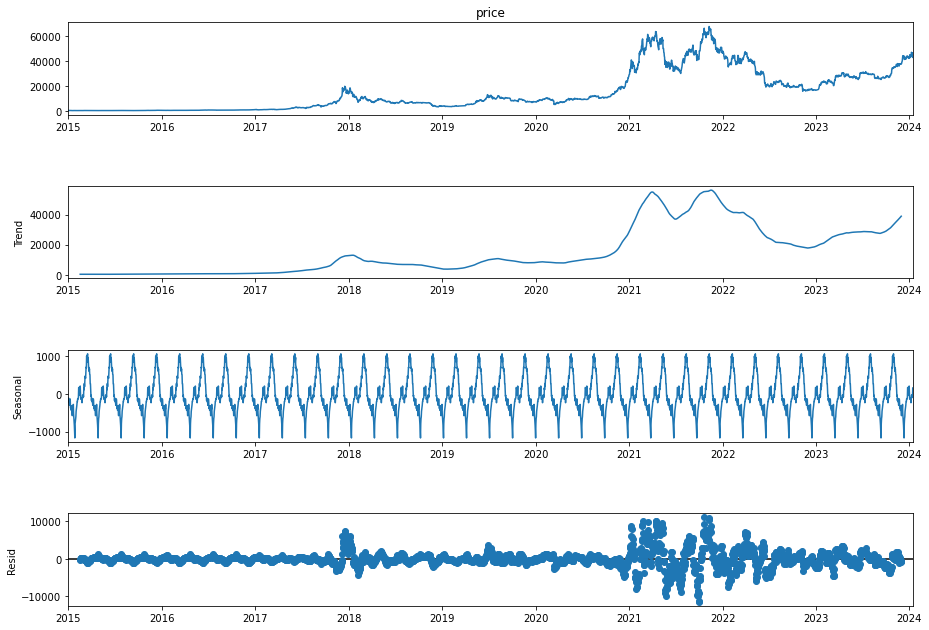

In [17]:
result = seasonal_decompose(df['price'], model='additive', period=90)
fig = result.plot()
fig.set_size_inches(15, 10)
plt.show()

In [18]:
df['price_trend'] = result.trend
df['price_seasonal'] = result.seasonal
df['price_resid'] = result.resid

The purpose of this code segment is to extract and save the components of trend, seasonality, and residuals from the decomposition of the time series of price (price) into separate columns in the DataFrame.

In [19]:
result = adfuller(df['total_volume'])
print('ADF Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Used Lags: %d' % result[2])
print('Number of Observations: %d' % result[3])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] > 0.05:
    print("Time series is nonstationary")
else:
    print("Time series is stationary")

ADF Test Statistic: -2.323652
p-value: 0.164453
Used Lags: 27
Number of Observations: 3272
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time series is nonstationary


ADF Test Statistic: -2.323652, which suggests that the time series is non-stationary. p-value: 0.164453, exceeds conventional significance thresholds, indicating non-stationarity. Used Lags: 27. Number of Observations: 3272. Critical Values: -3.432 (1%), -2.862 (5%), -2.567 (10%). We conclude that the time series is likely not stationary.

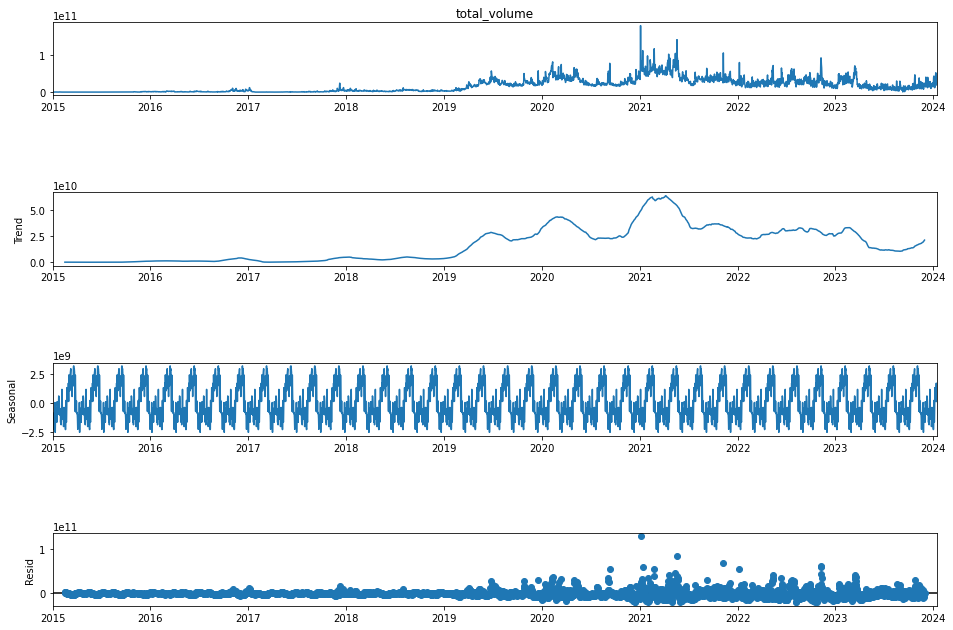

In [20]:
result = seasonal_decompose(df['total_volume'], model='additive', period=90)
df['total_volume_trend'] = result.trend
df['total_volume_seasonal'] = result.seasonal
df['total_volume_resid'] = result.resid
fig = result.plot()
fig.set_size_inches(15, 10)
plt.show()

In [21]:
result = adfuller(df['total_volume'])
print('ADF Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Used Lags: %d' % result[2])
print('Number of Observations: %d' % result[3])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] > 0.05:
    print("Time series is nonstationary")
else:
    print("Time series is stationary")

ADF Test Statistic: -2.323652
p-value: 0.164453
Used Lags: 27
Number of Observations: 3272
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time series is nonstationary


p-value: 0.164453, suggesting the non-stationarity of the series.
Used Lags: 27.
Number of Observations: 3272.
Critical Values: -3.432 (1%), -2.862 (5%), -2.567 (10%).
Conclusion: The time series is likely non-stationary.

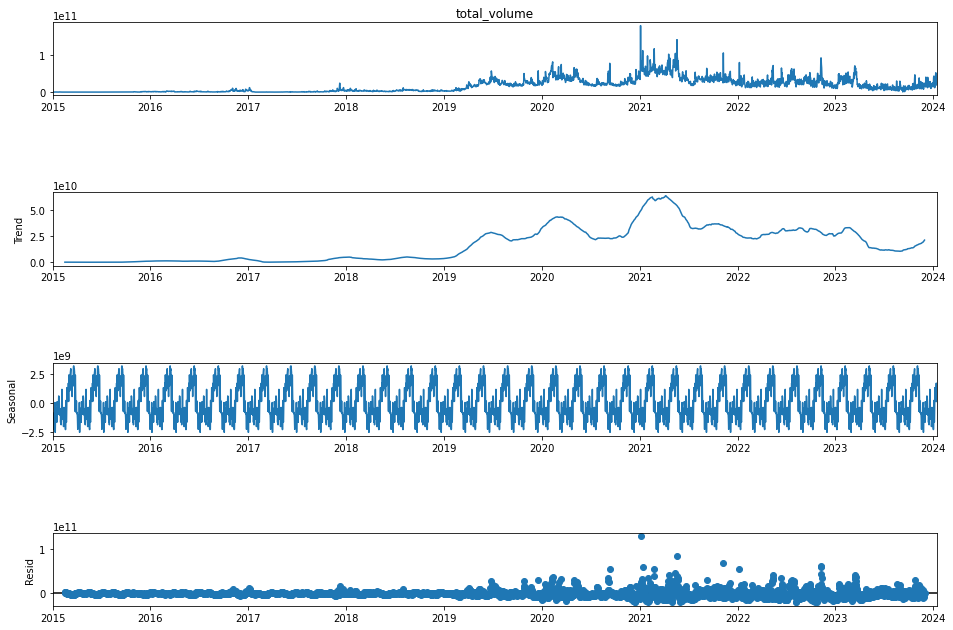

In [22]:
result = seasonal_decompose(df['total_volume'], model='additive', period=90)
df['total_volume_trend'] = result.trend
df['total_volume_seasonal'] = result.seasonal
df['total_volume_resid'] = result.resid
fig = result.plot()
fig.set_size_inches(15, 10)
plt.show()

In this part, we conduct a correlation analysis of selected features: 'price', 'total_volume', and 'market_cap'. The goal is to identify and visualize the relationships between these variables. We use a correlation matrix to assess whether and how strongly the variables are related to each other. Then, we create a heatmap, which allows for a quick and intuitive evaluation of these relationships. Correlation values are displayed on the map, and different shades of colors indicate the strength and direction of the correlation.

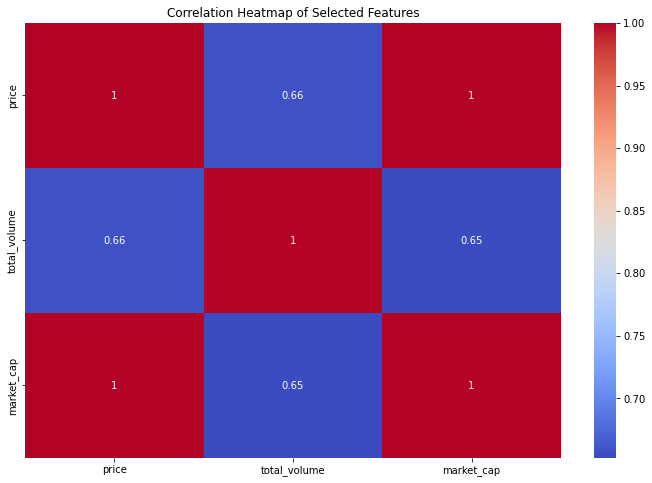

In [23]:
selected_columns = df[['price', 'total_volume', 'market_cap']]
corr_matrix = selected_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

The heatmap shows that all features are correlated in a similar manner, i.e., if one value increases, the others increase in a similar way.

The next step in the data analysis will be to examine the correlations between individual features. This will be used to create new independent variables related to lags.

C:\Users\micha\AppData\Local\Temp\ipykernel_9192\2743663914.py:1: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  correlations = ccf(df['price'], df['total_volume'], unbiased=True)


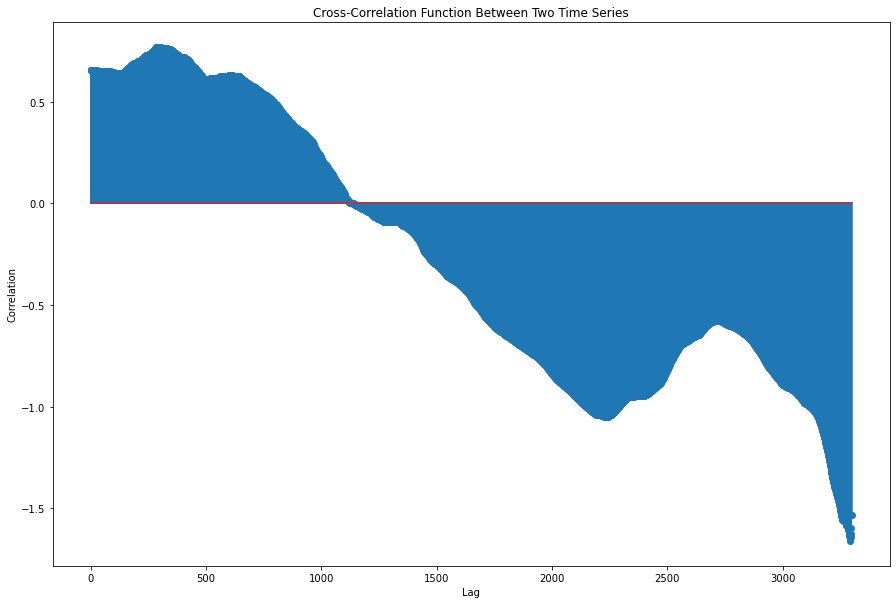

In [24]:
correlations = ccf(df['price'], df['total_volume'], unbiased=True)
plt.figure(figsize=(15, 10))
plt.stem(range(len(correlations)), correlations, use_line_collection=False)
plt.title('Cross-Correlation Function Between Two Time Series')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_9192\991583184.py:2: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  correlations = ccf(df['price'], df['total_volume'], unbiased=True)[:max_lags]


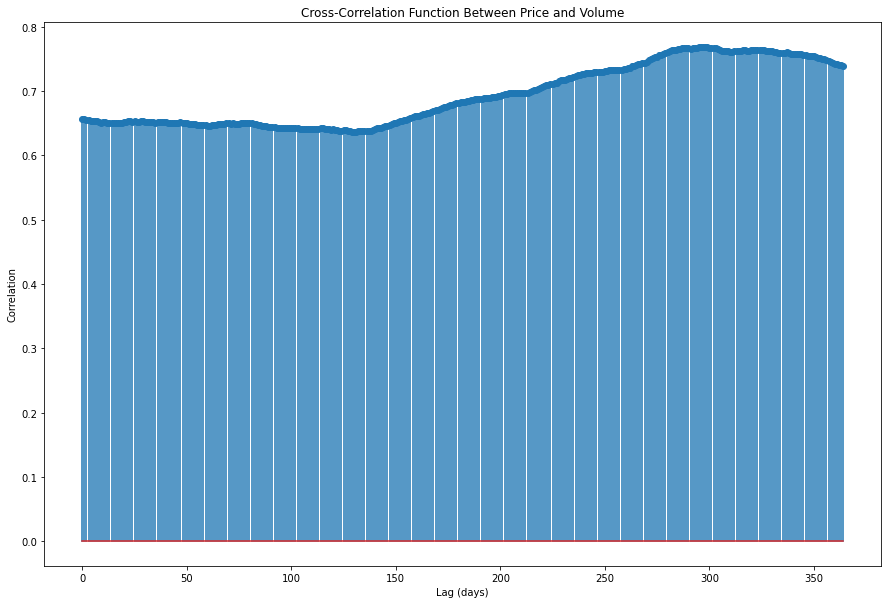

In [25]:
max_lags = 365
correlations = ccf(df['price'], df['total_volume'], unbiased=True)[:max_lags]
plt.figure(figsize=(15, 10))
plt.stem(range(len(correlations)), correlations, use_line_collection=False)
plt.title('Cross-Correlation Function Between Price and Volume')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()

In [26]:
max_corr_lag = np.argmax(correlations)
print("Lag for highest correlation:", max_corr_lag)

Lag for highest correlation: 296


In [27]:
df['lagged_total_volume'] = df['total_volume'].shift(296)
df.dropna(inplace=True)

As indicated by the above analysis, the 'price' time series is correlated with 'total_volume' at various time lags. It is important to note that the method used here is a form of technical analysis. Domain knowledge is extremely important during this exercise. The greatest change in correlation occurs around the 3000th day, which requires us to analyze a shorter period to draw conclusions. Subsequently, we examined the correlation over 350 days. The highest correlation corresponds to 296 days. Therefore, we create a new feature corresponding to this lag.

C:\Users\micha\AppData\Local\Temp\ipykernel_9192\1178700310.py:1: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  correlations = ccf(df['price'], df['market_cap'], unbiased=True)


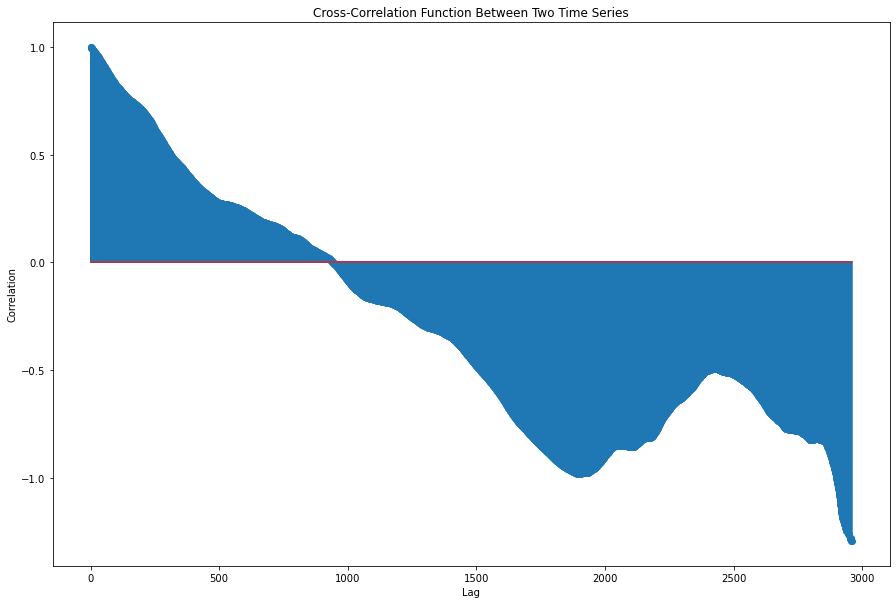

In [28]:
correlations = ccf(df['price'], df['market_cap'], unbiased=True)
plt.figure(figsize=(15, 10))
plt.stem(range(len(correlations)), correlations, use_line_collection=False)
plt.title('Cross-Correlation Function Between Two Time Series')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_9192\938858703.py:2: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  correlations = ccf(df['price'], df['market_cap'], unbiased=True)[:max_lags]


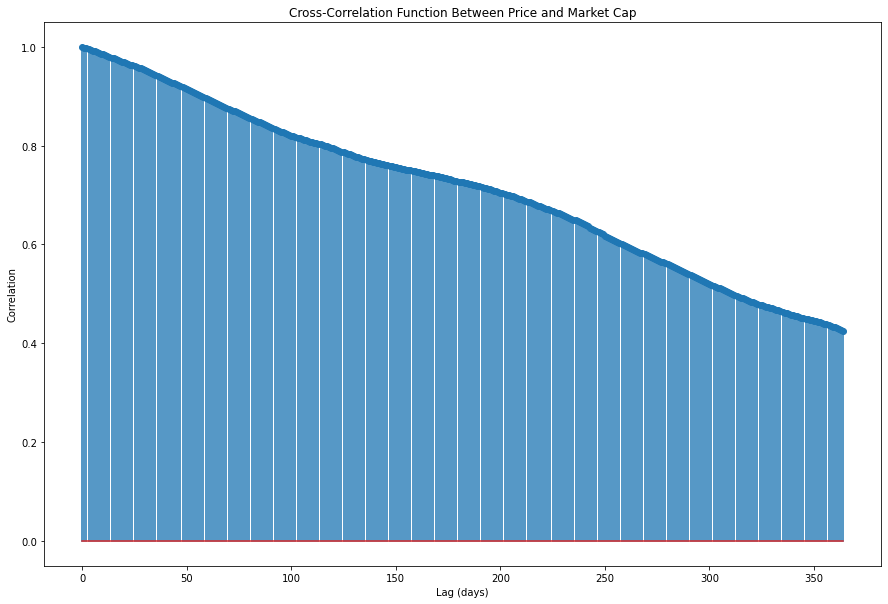

In [29]:
max_lags = 365
correlations = ccf(df['price'], df['market_cap'], unbiased=True)[:max_lags]
plt.figure(figsize=(15, 10))
plt.stem(range(len(correlations)), correlations, use_line_collection=False)
plt.title('Cross-Correlation Function Between Price and Market Cap')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()

In this case, the features 'price' and 'market_cap' show the highest correlation on day 1. Creating a new lag feature will not provide additional information.

Next, we will generate additional features based on statistical tools such as median, mean, etc.

In [30]:
periods = {
    'week': 7,
    'month': 30,
    'quarter': 90,
    'semester': 182,
    'year': 365
}
columns_to_analyze = ['price', 'total_volume', 'market_cap']
for period, days in periods.items():
    for col in columns_to_analyze:
        df[f'{col}_moving_average_{period}'] = df[col].rolling(window=days, min_periods=1).mean()
        df[f'{col}_max_{period}'] = df[col].rolling(window=days, min_periods=1).max()
        df[f'{col}_min_{period}'] = df[col].rolling(window=days, min_periods=1).min()
        df[f'{col}_std_{period}'] = df[col].rolling(window=days, min_periods=1).std()
        df[f'{col}_median_{period}'] = df[col].rolling(window=days, min_periods=1).median()
        df[f'{col}_skew_{period}'] = df[col].rolling(window=days, min_periods=1).skew()
        df[f'{col}_kurtosis_{period}'] = df[col].rolling(window=days, min_periods=1).kurt()
        df[f'{col}_quartile_change_{period}'] = df[col].rolling(window=days, min_periods=1).quantile(0.75) - df[col].rolling(window=days, min_periods=1).quantile(0.25)
        df[f'{col}_sum_{period}'] = df[col].rolling(window=days, min_periods=1).sum()

C:\Users\micha\AppData\Local\Temp\ipykernel_9192\2127449324.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_sum_{period}'] = df[col].rolling(window=days, min_periods=1).sum()
C:\Users\micha\AppData\Local\Temp\ipykernel_9192\2127449324.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_moving_average_{period}'] = df[col].rolling(window=days, min_periods=1).mean()
C:\Users\micha\AppData\Local\Temp\ipykernel_9192\2127449324.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

Working with financial data, we will create features containing information about trends, momentum, and volatility of the data. Indicators such as RSI (Relative Strength Index), MACD (Moving Average Convergence Divergence), and Bollinger Bands are widely used in financial analysis to assess market conditions and make investment decisions.

In [31]:
def calculate_rsi(data, window_length=14):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=window_length).mean()
    roll_down = down.abs().rolling(window=window_length).mean()
    rs = roll_up / roll_down
    return 100.0 - (100.0 / (1.0 + rs))
def calculate_macd(data, span_fast=12, span_slow=26, span_signal=9):
    fast_ema = data.ewm(span=span_fast, adjust=False).mean()
    slow_ema = data.ewm(span=span_slow, adjust=False).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=span_signal, adjust=False).mean()
    return macd, signal
def calculate_bollinger_bands(data, window=20):
    ma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = ma + (std * 2)
    lower_band = ma - (std * 2)
    return upper_band, lower_band
columns_to_analyze = ['price', 'total_volume', 'market_cap']
for col in columns_to_analyze:
    df[f'{col}_RSI'] = calculate_rsi(df[col])
    df[f'{col}_MACD'], df[f'{col}_MACD_Signal'] = calculate_macd(df[col])
    df[f'{col}_Bollinger_Upper'], df[f'{col}_Bollinger_Lower'] = calculate_bollinger_bands(df[col])

C:\Users\micha\AppData\Local\Temp\ipykernel_9192\4056991681.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_RSI'] = calculate_rsi(df[col])
C:\Users\micha\AppData\Local\Temp\ipykernel_9192\4056991681.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_MACD'], df[f'{col}_MACD_Signal'] = calculate_macd(df[col])
C:\Users\micha\AppData\Local\Temp\ipykernel_9192\4056991681.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [32]:
df

,price,total_volume,market_cap,year,month,day,day_of_week,quarter,day_of_year,week_of_year,...,total_volume_RSI,total_volume_MACD,total_volume_MACD_Signal,total_volume_Bollinger_Upper,total_volume_Bollinger_Lower,market_cap_RSI,market_cap_MACD,market_cap_MACD_Signal,market_cap_Bollinger_Upper,market_cap_Bollinger_Lower
date,,,,,,,,,,,,,,,,,,,,,
2015-10-25,284.749000,3.368603e+08,4.203956e+09,2015,10,25,6,4,298,43,...,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN
2015-10-26,285.515900,2.215839e+08,4.215885e+09,2015,10,26,0,4,299,44,...,NaN,-9.195837e+06,-1.839167e+06,NaN,NaN,NaN,9.516029e+05,1.903206e+05,NaN,NaN
2015-10-27,294.809400,3.293975e+08,4.354733e+09,2015,10,27,1,4,300,44,...,NaN,-7.695241e+06,-3.010382e+06,NaN,NaN,NaN,1.276250e+07,2.704757e+06,NaN,NaN
2015-10-28,303.636600,3.872096e+08,4.486178e+09,2015,10,28,2,4,301,44,...,NaN,-1.820080e+06,-2.772322e+06,NaN,NaN,NaN,3.235624e+07,8.635052e+06,NaN,NaN
2015-10-29,313.907300,5.431638e+08,4.639134e+09,2015,10,29,3,4,302,44,...,NaN,1.524450e+07,8.310424e+05,NaN,NaN,NaN,5.954037e+07,1.881612e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-26,37809.852866,7.505380e+09,7.395367e+11,2023,11,26,6,4,330,47,...,48.112772,-3.458451e+08,2.592996e+08,3.314559e+10,2.440473e+09,54.578157,2.147273e+10,2.404537e+10,7.517009e+11,6.842319e+11
2023-11-27,37491.838186,1.022911e+10,7.333768e+11,2023,11,27,0,4,331,48,...,50.584971,-8.229554e+08,4.284858e+07,3.323323e+10,2.104013e+09,51.978214,2.061211e+10,2.335872e+10,7.506851e+11,6.902209e+11
2023-11-28,37250.169051,1.797913e+10,7.280402e+11,2023,11,28,1,4,332,48,...,49.973753,-5.691461e+08,-7.955036e+07,3.319793e+10,2.078961e+09,53.345785,1.927723e+10,2.254242e+10,7.494315e+11,6.951124e+11


The result of the conducted analysis is an increase in the number of learning features from 3 to 167.

Some predictive models perform better if they do not contain NaN values. Generated data such as moving averages will inherently have empty rows for a period shorter than the number of days for which the average is calculated. These fields need to be filled with values that will not distort predictions. We have analyzed the independent variables above. The best solution will be to fill NaN values with the mean.

In [33]:
df.fillna(df.mean(), inplace=True)

### Preparing Data for Model Training.

The aim of the analysis is to prepare predictive models for the 'price' value three days ahead.

In [34]:
df['price_target'] = df['price'].shift(-3)

C:\Users\micha\AppData\Local\Temp\ipykernel_9192\1353978934.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['price_target'] = df['price'].shift(-3)


In [35]:
df = df.drop(df.index[-3:])

Next, we divide the data into training, validation, and test sets.

In [36]:
df.sort_values(by='date', inplace=True)
total_rows = len(df)
train_split = int(total_rows * 0.7)
validation_split = int(total_rows * 0.85)
train_data = df.iloc[:train_split, :]
validation_data = df.iloc[train_split:validation_split, :]
test_data = df.iloc[validation_split:, :]
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_validation = validation_data.iloc[:, :-1]
y_validation = validation_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [37]:
import xgboost as xgb
D_train = xgb.DMatrix(X_train, label=y_train)
D_validation = xgb.DMatrix(X_validation, label=y_validation)
D_test = xgb.DMatrix(X_test, label=y_test)

### Training Models: Decision Tree, Random Forest, and XGBoost.




In [38]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error

Before training the models, it is necessary to determine the optimal hyperparameters. RandomizedSearchCV will be used for optimization purposes.

In [39]:
models_params = {
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': randint(1, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20)
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(10, 500),
            'max_depth': randint(1, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20),
            'bootstrap': [True, False]
        }
    }
}
best_models = {}
for model_name, mp in models_params.items():
    random_search = RandomizedSearchCV(mp['model'], mp['params'], cv=5, n_iter=25, scoring='neg_mean_squared_error', n_jobs=-1, random_state=1)
    random_search.fit(X_train, y_train)
    best_models[model_name] = random_search.best_estimator_
validation_scores = {}
for model_name, best_model in best_models.items():
    y_val_pred = best_model.predict(X_validation)
    score = mean_squared_error(y_validation, y_val_pred)
    validation_scores[model_name] = score
for model_name, best_model in best_models.items():
    print(f'{model_name} - Best Model: {best_model}')
    print(f'{model_name} - Validation MSE: {validation_scores[model_name]}')

DecisionTreeRegressor - Best Model: DecisionTreeRegressor(max_depth=8, min_samples_leaf=9, min_samples_split=11)
DecisionTreeRegressor - Validation MSE: 61267438.322005935
RandomForestRegressor - Best Model: RandomForestRegressor(bootstrap=False, max_depth=8, min_samples_leaf=9,
                      min_samples_split=11, n_estimators=205)
RandomForestRegressor - Validation MSE: 60727126.49070613


In [40]:
param_dist = {
    'booster': ['dart', 'gbtree'],
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 500),
    'subsample': uniform(0.5, 0.5),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'rate_drop': uniform(0.0, 0.2),
    'one_drop': [True, False],
    'num_parallel_tree': randint(1, 5)
}
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_dist, n_iter=25, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)
random_search.fit(X_train, y_train, eval_set=[(X_validation, y_validation)], early_stopping_rounds=25, verbose=False)
best_hyperparams = random_search.best_params_
print("Best hyperparameters:")
print(best_hyperparams)

C:\Users\micha\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best hyperparameters:
{'booster': 'dart', 'learning_rate': 0.2177308098670811, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 364, 'num_parallel_tree': 2, 'one_drop': False, 'rate_drop': 0.10375812434867322, 'subsample': 0.8515094794475889}


The above results will be used to train the models.



In [41]:
tree_regressor = DecisionTreeRegressor(
    max_depth=9,
    min_samples_leaf=9,
    min_samples_split=11
)
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=9, min_samples_split=11)

In [42]:
y_pred_tree = tree_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_tree)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 59329209.35068612
RMSE: 7702.545640934958


In [43]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_tree,
    'Difference': y_test - y_pred_tree
})
results_df['Percent Difference'] = results_df.apply(
    lambda row: ((row['Actual'] - row['Predicted']) / row['Predicted']) * 100 if row['Predicted'] != 0 else None, 
    axis=1
)
last_10_days = results_df.tail(10)
print(last_10_days)

                  Actual     Predicted   Difference  Percent Difference
date                                                                   
2023-11-18  37489.298471  30623.239151  6866.059320           22.421075
2023-11-19  35965.360361  30623.239151  5342.121210           17.444664
2023-11-20  37464.832932  30623.239151  6841.593781           22.341183
2023-11-21  37293.316127  30623.239151  6670.076976           21.781096
2023-11-22  37738.931697  30623.239151  7115.692546           23.236250
2023-11-23  37809.852866  30623.239151  7186.613715           23.467843
2023-11-24  37491.838186  30623.239151  6868.599035           22.429368
2023-11-25  37250.169051  30623.239151  6626.929900           21.640199
2023-11-26  37802.236044  30623.239151  7178.996893           23.442970
2023-11-27  37810.346417  30623.239151  7187.107266           23.469455


In [44]:
forest_regressor = RandomForestRegressor(
    bootstrap=False,
    max_depth=8,
    min_samples_leaf=9,
    min_samples_split=11,
    n_estimators=205,
)
forest_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=8, min_samples_leaf=9,
                      min_samples_split=11, n_estimators=205)

In [45]:
y_pred_forest = forest_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_forest)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 59329209.35068541
RMSE: 7702.545640934912


In [46]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_forest,
    'Difference': y_test - y_pred_forest
})

results_df['Percent Difference'] = results_df.apply(
    lambda row: ((row['Actual'] - row['Predicted']) / row['Predicted']) * 100 if row['Predicted'] != 0 else None, 
    axis=1
)
last_10_days = results_df.tail(10)
print(last_10_days)

                  Actual     Predicted   Difference  Percent Difference
date                                                                   
2023-11-18  37489.298471  30623.239151  6866.059320           22.421075
2023-11-19  35965.360361  30623.239151  5342.121210           17.444664
2023-11-20  37464.832932  30623.239151  6841.593781           22.341183
2023-11-21  37293.316127  30623.239151  6670.076976           21.781096
2023-11-22  37738.931697  30623.239151  7115.692546           23.236250
2023-11-23  37809.852866  30623.239151  7186.613715           23.467843
2023-11-24  37491.838186  30623.239151  6868.599035           22.429368
2023-11-25  37250.169051  30623.239151  6626.929900           21.640199
2023-11-26  37802.236044  30623.239151  7178.996893           23.442970
2023-11-27  37810.346417  30623.239151  7187.107266           23.469455


In [47]:
xgb_regressor = xgb.XGBRegressor(
    booster='dart',
    rate_drop=0.10375812434867322,
    one_drop=False,
    objective='reg:squarederror',
    n_estimators=364,
    learning_rate=00.2177308098670811,
    min_child_weight=8,
    subsample=0.8515094794475889,
    max_depth=4,
    num_parallel_tree=2
)
xgb_regressor.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_validation, y_validation)],
        early_stopping_rounds=25,
        verbose=False)

C:\Users\micha\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2177308098670811,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             n_estimators=364, n_jobs=None, num_parallel_tree=2, one_drop=False,
             predictor=None, ...)

In [48]:
y_pred_xgb = xgb_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 15000123.527146336
RMSE: 3872.999293460604


In [49]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_xgb,
    'Difference': y_test - y_pred_xgb
})
results_df['Percent Difference'] = results_df.apply(
    lambda row: ((row['Actual'] - row['Predicted']) / row['Predicted']) * 100 if row['Predicted'] != 0 else None, 
    axis=1
)
last_10_days = results_df.tail(10)
print(last_10_days)

                  Actual     Predicted   Difference  Percent Difference
date                                                                   
2023-11-18  37489.298471  33409.214844  4080.083627           12.212450
2023-11-19  35965.360361  33615.871094  2349.489267            6.989226
2023-11-20  37464.832932  33881.109375  3583.723557           10.577350
2023-11-21  37293.316127  34182.257812  3111.058315            9.101383
2023-11-22  37738.931697  34585.679688  3153.252010            9.117219
2023-11-23  37809.852866  33924.945312  3884.907554           11.451478
2023-11-24  37491.838186  33643.875000  3847.963186           11.437336
2023-11-25  37250.169051  33577.328125  3672.840926           10.938455
2023-11-26  37802.236044  34173.957031  3628.279013           10.617088
2023-11-27  37810.346417  33553.585938  4256.760479           12.686455


### The Stacking Method and Majority Voting.

We will try to use the trained models simultaneously in order to analyze whether it will be possible to achieve better results.

In [50]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [51]:
base_models = [
    ('tree', tree_regressor),
    ('rf', forest_regressor),
    ('xgb', xgb_regressor)
]
meta_model = LinearRegression()
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('tree',
                               DecisionTreeRegressor(max_depth=9,
                                                     min_samples_leaf=9,
                                                     min_samples_split=11)),
                              ('rf',
                               RandomForestRegressor(bootstrap=False,
                                                     max_depth=8,
                                                     min_samples_leaf=9,
                                                     min_samples_split=11,
                                                     n_estimators=205)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster='dart',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2177308098670811,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=8,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=364, n_jobs=None,
                                            num_parallel_tree=2, one_drop=False,
                                            predictor=None, ...))],
                  final_estimator=LinearRegression())

In [52]:
y_pred_stacking = stacking_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_stacking)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 780508264.6967468
RMSE: 27937.5780034123


In [53]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_stacking,
    'Difference': y_test - y_pred_stacking
})
results_df['Percent Difference'] = results_df.apply(
    lambda row: ((row['Actual'] - row['Predicted']) / row['Predicted']) * 100 if row['Predicted'] != 0 else None, 
    axis=1
)
last_10_days = results_df.tail(10)
print(last_10_days)

                  Actual     Predicted    Difference  Percent Difference
date                                                                    
2023-11-18  37489.298471  46948.283987  -9458.985516          -20.147670
2023-11-19  35965.360361  46816.196104 -10850.835743          -23.177525
2023-11-20  37464.832932  46536.043675  -9071.210743          -19.492871
2023-11-21  37293.316127  46292.399586  -8999.083459          -19.439656
2023-11-22  37738.931697  46060.702624  -8321.770927          -18.066965
2023-11-23  37809.852866  46544.805070  -8734.952204          -18.766761
2023-11-24  37491.838186  46732.184734  -9240.346548          -19.772982
2023-11-25  37250.169051  46791.220570  -9541.051518          -20.390687
2023-11-26  37802.236044  46405.365497  -8603.129454          -18.539083
2023-11-27  37810.346417  46815.746413  -9005.399996          -19.235836


In [ ]:
reg1 = tree_regressor
reg2 = forest_regressor
reg3 = xgb_regressor
reg4 = stacking_regressor
voting_reg = VotingRegressor(estimators=[('reg1', reg1), ('reg2', reg2), ('reg3', reg3),  ('reg4', reg4)])
reg_labels = ['tree_regressor', 'forest_regressor', 'xgb_regressor','stacking_regressor']
reg_labels += ['Majority Voting']
all_reg = [reg1, reg2, reg3, reg4, voting_reg]
for reg, label in zip(all_reg, reg_labels):
    scores = cross_val_score(estimator=reg,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1)  
    print("MSE: %0.2f (+/- %0.2f) [%s]" % (-scores.mean(), scores.std(), label))

MSE: 91914151.35 (+/- 270565492.07) [tree_regressor]
MSE: 92471310.19 (+/- 270277694.46) [forest_regressor]
MSE: 92541336.44 (+/- 275384955.41) [xgb_regressor]


In [ ]:
voting_reg.fit(X_train, y_train)
y_pred_voting = voting_reg.predict(X_test)
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_voting,
    'Difference': y_test - y_pred_voting
})
results_df['Percent Difference'] = results_df.apply(
    lambda row: ((row['Actual'] - row['Predicted']) / row['Predicted']) * 100 if row['Predicted'] != 0 else None, 
    axis=1
)
last_10_days = results_df.tail(10)
print(last_10_days)

The results of the above experiment are quite surprising. The predicted values from the stacking method, in contrast to individual models, are higher than the actual data. Therefore, the voting method was used to "flatten" the forecasts and bring them closer to the actual values. The effect was intentional, and the predictions using voting are the closest to the actual data.